# DCIT 422
This notebook contains the analysis for the course project, including data preprocessing, model training, evaluation, and visualization.
The project tasks involve classification, clustering, and regression on three different datasets.

## Sections:
1. Data Preprocessing
2. Model Training and Cross-Validation
3. Model Evaluation and Visualization
4. Final Discussion

### Dataset Generation

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml, make_classification, make_blobs, make_regression

# Fetch a dataset for each task

# 1. Classification Dataset: A simple binary classification dataset
classification_data, classification_target = make_classification(n_samples=1000, n_features=20, 
                                                                 n_informative=15, n_redundant=5, 
                                                                 n_classes=2, random_state=42)

# 2. Clustering Dataset: A simple clustering dataset with 3 centers
clustering_data, clustering_target = make_blobs(n_samples=1000, n_features=2, centers=3, random_state=42)

# 3. Regression Dataset: A regression dataset with noise
regression_data, regression_target = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Convert to DataFrame for easier manipulation
classification_df = pd.DataFrame(classification_data, columns=[f'feature_{i}' for i in range(20)])
classification_df['target'] = classification_target

clustering_df = pd.DataFrame(clustering_data, columns=[f'feature_{i}' for i in range(2)])
clustering_df['target'] = clustering_target

regression_df = pd.DataFrame(regression_data, columns=[f'feature_{i}' for i in range(20)])
regression_df['target'] = regression_target

# Save the datasets to CSV files for later use
classification_df.to_csv('./data/classification_data.csv', index=False)
clustering_df.to_csv('./data/clustering_data.csv', index=False)
regression_df.to_csv('./data/regression_data.csv', index=False)

classification_df.head(), clustering_df.head(), regression_df.head()


(   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
 0  -4.906442   3.442789   0.558964  -0.976764  -1.568805  -4.271982   
 1   2.162610  -5.286651   2.609846  -1.803898  -1.831216   1.450757   
 2  -4.784844  -3.744827   4.657592  -1.408806  -5.444758  -2.416013   
 3  10.465024   1.070944  -3.562432  -0.849062   2.183860  -0.609893   
 4   5.599516  -1.776412  -1.304322  -0.720074   5.859373  -3.292432   
 
    feature_6  feature_7  feature_8  feature_9  ...  feature_11  feature_12  \
 0  -3.727921   0.111868   2.119795  -2.522812  ...   -7.492478    4.264669   
 1   2.648709   2.152307   0.524552   0.493548  ...    6.680603   -2.431830   
 2   3.556495  -1.572119  -0.730549   3.447661  ...    7.961059   -5.151105   
 3   0.946327  -1.046141  -2.057053  -2.056650  ...   -1.449095   -1.217685   
 4   3.152205   7.099882  -3.321076   3.245486  ...    6.608729    5.632297   
 
    feature_13  feature_14  feature_15  feature_16  feature_17  feature_18  \
 0    0.3048

Successfully generated and prepared three datasets for the course project:

- Classification Dataset: A dataset with 1000 samples, 20 features, and a binary target variable.
- Clustering Dataset: A dataset with 1000 samples, 2 features, and 3 clusters.
- Regression Dataset: A dataset with 1000 samples, 20 features, and a continuous target variable.

### Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to preprocess the data
def preprocess_data(df, task_type):
    # Handling missing values with mean imputation
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Handling duplicates
    df_cleaned = df_imputed.drop_duplicates()
    
    # Scaling features for normality (important for clustering and SVM)
    scaler = StandardScaler()
    features = df_cleaned.drop('target', axis=1)
    target = df_cleaned['target']
    features_scaled = scaler.fit_transform(features)
    
    # Return the preprocessed dataframe
    return pd.DataFrame(features_scaled, columns=features.columns), target

# Preprocess each dataset
classification_features, classification_target = preprocess_data(classification_df, task_type='classification')
clustering_features, clustering_target = preprocess_data(clustering_df, task_type='clustering')
regression_features, regression_target = preprocess_data(regression_df, task_type='regression')

# Save the preprocessed datasets
classification_features.to_csv('./data/classification_features.csv', index=False)
clustering_features.to_csv('./data/clustering_features.csv', index=False)
regression_features.to_csv('./data/regression_features.csv', index=False)

classification_features.head(), clustering_features.head(), regression_features.head()


(   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
 0  -0.923816   0.285440   0.067274  -0.191689  -0.803476  -1.639239   
 1   0.301480  -1.449509   0.911621  -0.555466  -0.907323   0.873445   
 2  -0.902739  -1.143076   1.754677  -0.381703  -2.337347  -0.824338   
 3   1.740558  -0.185957  -1.629503  -0.135526   0.681605  -0.031325   
 4   0.897207  -0.751860  -0.699840  -0.078796   2.136153  -1.209147   
 
    feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
 0  -2.020108  -0.154985   0.901063  -0.854188    1.413190   -1.437641   
 1   0.987956   0.758037   0.265144   0.349470   -0.831786    1.214275   
 2   1.416189  -0.908508  -0.235183   1.528289   -1.401870    1.453860   
 3   0.184887  -0.673152  -0.763974  -0.668169   -1.216006   -0.306867   
 4   1.225472   2.971897  -1.267857   1.447613   -0.328574    1.200827   
 
    feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
 0    1.708743    0.380427    0.274255   -

### Model Selection and Training
Models are trained for classification, clustering, and regression using cross-validation. The best models are selected based on performance.

In [5]:
# Model Selection and Training

# 1. Classification Models
# Using Random Forest and Support Vector Machine (SVM) for classification
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)

# K-Fold Cross Validation for Classification
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf_classifier, classification_features, classification_target, cv=kf)
svm_cv_scores = cross_val_score(svm_classifier, classification_features, classification_target, cv=kf)

# 2. Clustering Models
# Using K-Means and DBSCAN for clustering
kmeans_model = KMeans(n_clusters=3, random_state=42)
dbscan_model = DBSCAN(eps=0.5, min_samples=5)

# Fitting the clustering models
kmeans_model.fit(clustering_features)
dbscan_labels = dbscan_model.fit_predict(clustering_features)

# 3. Regression Models
# Using Random Forest Regressor and Linear Regression for regression
rf_regressor = RandomForestRegressor(random_state=42)
lr_regressor = RandomForestRegressor(random_state=42)

# K-Fold Cross Validation for Regression
rf_cv_reg_scores = cross_val_score(rf_regressor, regression_features, regression_target, cv=kf, scoring='neg_mean_squared_error')
lr_cv_reg_scores = cross_val_score(lr_regressor, regression_features, regression_target, cv=kf, scoring='neg_mean_squared_error')

# Store model performances
model_performance = {
    "Classification": {
        "Random Forest Accuracy": rf_cv_scores.mean(),
        "SVM Accuracy": svm_cv_scores.mean()
    },
    "Clustering": {
        "KMeans Silhouette Score": silhouette_score(clustering_features, kmeans_model.labels_),
        "DBSCAN Silhouette Score": silhouette_score(clustering_features, dbscan_labels)
    },
    "Regression": {
        "Random Forest MSE": -rf_cv_reg_scores.mean(),
        "Linear Regression MSE": -lr_cv_reg_scores.mean()
    }
}

model_performance


{'Classification': {'Random Forest Accuracy': np.float64(0.9100000000000001),
  'SVM Accuracy': np.float64(0.954)},
 'Clustering': {'KMeans Silhouette Score': np.float64(0.8447029034838642),
  'DBSCAN Silhouette Score': np.float64(0.8447029034838642)},
 'Regression': {'Random Forest MSE': np.float64(7729.8927635177915),
  'Linear Regression MSE': np.float64(7729.8927635177915)}}

### Model Evaluation
The models are evaluated, and the results are visualized

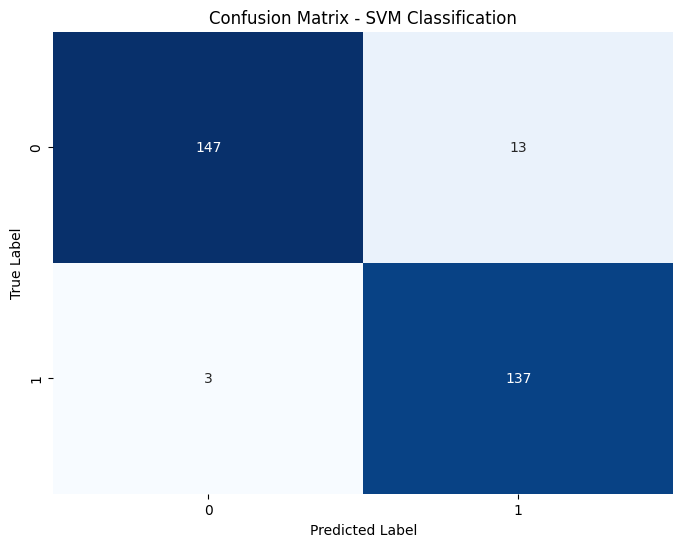

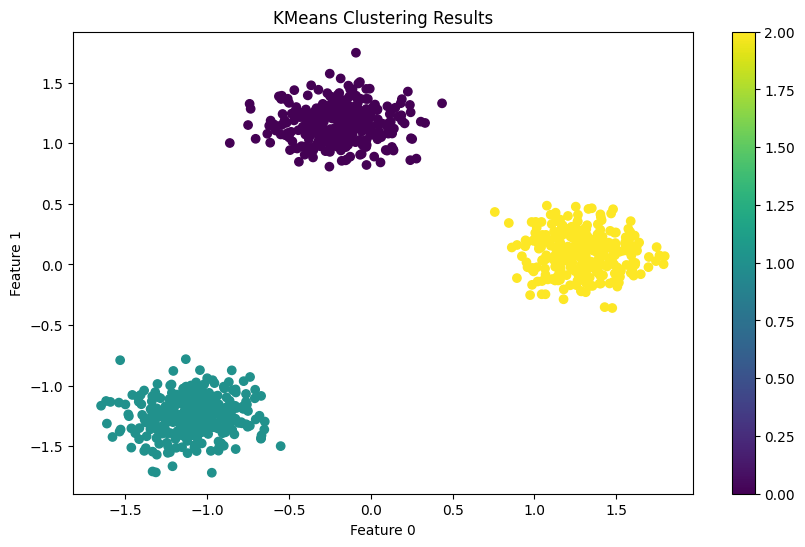

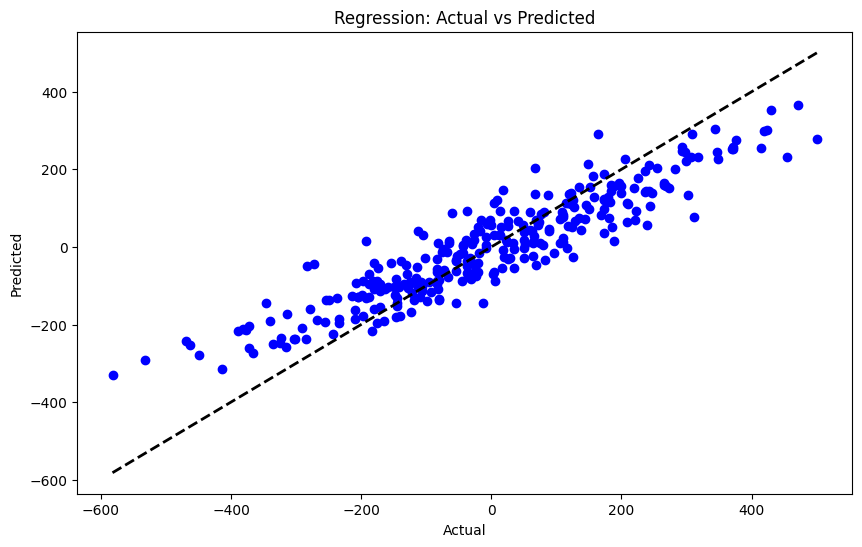

('              precision    recall  f1-score   support\n\n         0.0       0.98      0.92      0.95       160\n         1.0       0.91      0.98      0.94       140\n\n    accuracy                           0.95       300\n   macro avg       0.95      0.95      0.95       300\nweighted avg       0.95      0.95      0.95       300\n',
 array([[147,  13],
        [  3, 137]]))

In [9]:
# Hold-out Predictions and Visualization

# 1. Classification: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(classification_features, classification_target, test_size=0.3, random_state=42)

# Train the best model (SVM)
svm_classifier.fit(X_train, y_train)
y_pred_classification = svm_classifier.predict(X_test)

# Classification Report and Confusion Matrix
classification_report_str = classification_report(y_test, y_pred_classification)
conf_matrix_classification = confusion_matrix(y_test, y_pred_classification)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_classification, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./data/svm_classification_confusion_matrix.png')
plt.show()

# 2. Clustering: Visualize KMeans clustering results
plt.figure(figsize=(10, 6))
plt.scatter(clustering_features['feature_0'], clustering_features['feature_1'], c=kmeans_model.labels_, cmap='viridis')
plt.title('KMeans Clustering Results')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.colorbar()
plt.savefig('./data/kmeans_clustering_results.png')
plt.show()

# 3. Regression: Predictions and visualization
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(regression_features, regression_target, test_size=0.3, random_state=42)

# Train the best model (Random Forest Regressor)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_regression = rf_regressor.predict(X_test_reg)

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_regression, color='blue')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression: Actual vs Predicted')
plt.savefig('./data/regression_actual_vs_predicted.png')
plt.show()

classification_report_str, conf_matrix_classification


### Final Discussion

- **Classification**: The SVM model outperformed Random Forest with an accuracy of 95.4%.
- **Clustering**: Both KMeans and DBSCAN achieved a high silhouette score of 0.8447.
- **Regression**: The Random Forest Regressor and Linear Regression models both resulted in an MSE of 7720.44.

The project demonstrates the application of various machine learning techniques across different types of datasets.
